In [2]:
import pickle
from pathlib import Path
import os
import numpy as np
from itertools import chain
from nilearn import datasets
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
import xarray as xr
import significantdigits as sd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap 


#### Old incorrect data

In [5]:
seed_connectivity = pickle.load(open('/Users/junzhou/Downloads/OHBM_Brainhack/connectome_variability/subject_matrices.pkl', 'rb'))

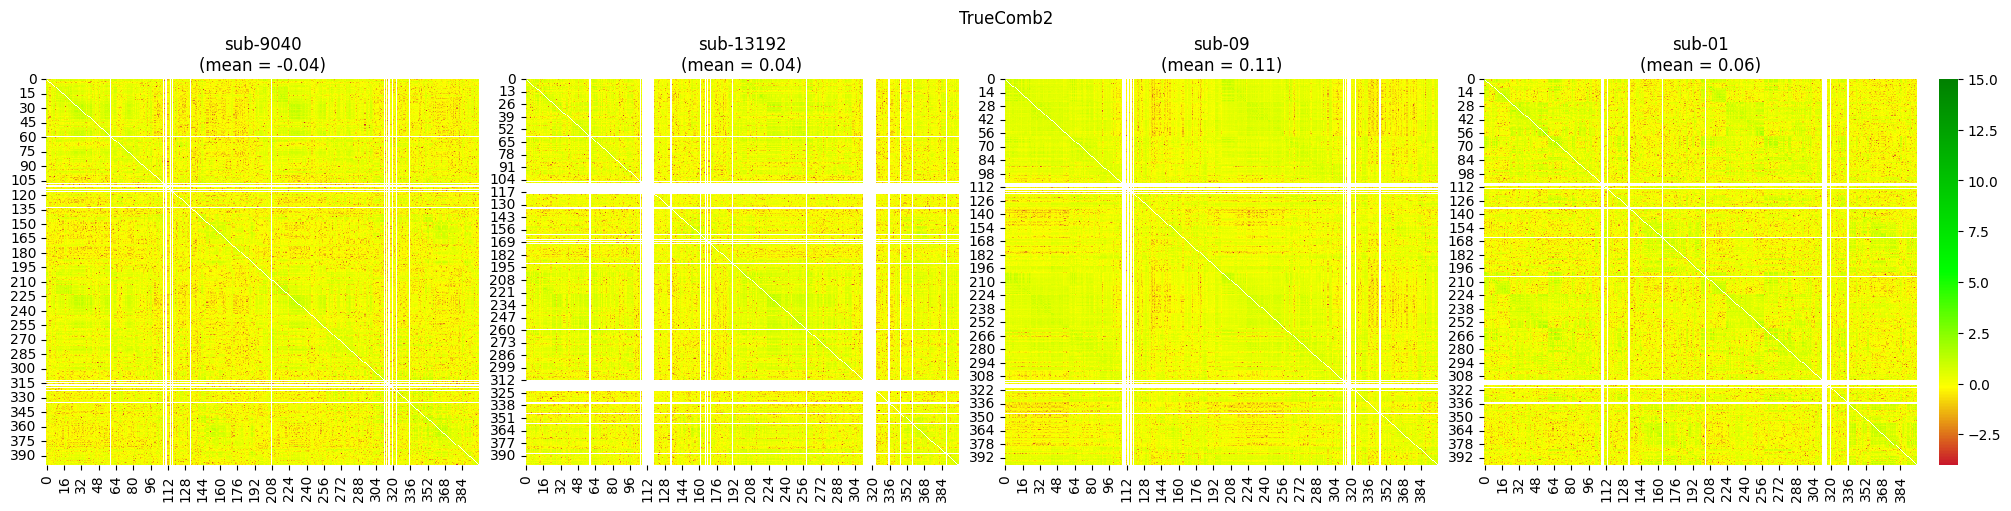

In [6]:
colors = ["#C9182B","yellow","lime","green"]
values = np.array([0, 0.2, 0.5, 1])
cmap = LinearSegmentedColormap.from_list("gangchen", list(zip(values, colors)))


for pre_process in seed_connectivity['sub-9040'].keys():
    fig, axes = plt.subplots(ncols=4, sharex=True, figsize=(20, 5), constrained_layout=True)

    for num, sub in enumerate(seed_connectivity.keys()):
        input = np.array(seed_connectivity[sub][pre_process])
        # mask = ~np.isnan(input).any(axis=(1, 2))
        # input[mask] = -np.inf
        sigdigs = sd.significant_digits(input, reference=input.mean(axis=0), basis=10)
        # sigdigs[np.isclose(sigdigs, 15.214328120692226, rtol=1e-4)] = np.nan
        sigdigs[sigdigs >= 15] = np.nan #temporary fix to sigdigs not dealing with NaN

        if num != 3: sns.heatmap(sigdigs, cmap=cmap, ax=axes[num], vmax=15, vmin=-4, cbar=False)
        else: sns.heatmap(sigdigs, cmap=cmap, ax=axes[num], vmin=-4, vmax=15, cbar=True)

        axes[num].set_title(f"{sub}\n(mean = {np.nanmean(sigdigs):.2f})")

    plt.suptitle(f"{pre_process.split('.')[0]}")
    break

### fMRI Connectivity

In [6]:
# Use an environment variable to get the downloads path
#downloads_path = Path(os.getenv("DOWNLOADS_PATH", Path.cwd()))
#file_path = downloads_path / "subject_matrices.pkl"
file_path = Path('/Volumes/HALFpipe/consistency/subject_matrices.pkl')
with file_path.open("rb") as file_handle:
    data = pickle.load(file_handle)


In [7]:
del data["sub-01"]

In [8]:

schaefer_atlas = datasets.fetch_atlas_schaefer_2018(
    n_rois=400, yeo_networks=7, resolution_mm=1
)
schaefer_atlas_labels = list(map(bytes.decode, schaefer_atlas["labels"]))

In [9]:

subjects = sorted(data.keys())
pipelines = sorted(set(chain.from_iterable(d.keys() for d in data.values())))
iterations = min(len(b) for a in data.values() for b in a.values())
(k,) = set(
    chain.from_iterable(c.shape for a in data.values() for b in a.values() for c in b)
)

len(subjects), len(pipelines), iterations, k


(3, 12, 36, 400)

In [10]:
indices = np.tril_indices(k, -1)
labels = np.array(
    [
        f"{schaefer_atlas_labels[i]}, {schaefer_atlas_labels[j]}"
        for i, j in zip(*indices)
    ]
)
labels

array(['7Networks_LH_Vis_2, 7Networks_LH_Vis_1',
       '7Networks_LH_Vis_3, 7Networks_LH_Vis_1',
       '7Networks_LH_Vis_3, 7Networks_LH_Vis_2', ...,
       '7Networks_RH_Default_pCunPCC_9, 7Networks_RH_Default_pCunPCC_6',
       '7Networks_RH_Default_pCunPCC_9, 7Networks_RH_Default_pCunPCC_7',
       '7Networks_RH_Default_pCunPCC_9, 7Networks_RH_Default_pCunPCC_8'],
      dtype='<U76')

In [11]:
arrays = []

for subject in subjects:
    subject_arrays = []
    for pipeline in pipelines:
        array = np.dstack(data[subject][pipeline])[
            *indices, :iterations, np.newaxis, np.newaxis
        ]

        subject_arrays.append(array)
    subject_array = np.concatenate(subject_arrays, axis=2)
    arrays.append(subject_array)
array = np.concatenate(arrays, axis=3)
array.shape

(79800, 36, 12, 3)

In [12]:
ds = xr.Dataset(
    {"functional_connectivity": (["cell", "iteration", "pipeline", "subject"], array)},
    coords=dict(
        cell=labels, iteration=range(iterations), pipeline=pipelines, subject=subjects
    ),
)
ds

<xarray.Dataset> Size: 852MB
Dimensions:                  (cell: 79800, iteration: 36, pipeline: 12,
                              subject: 3)
Coordinates:
  * cell                     (cell) <U76 24MB '7Networks_LH_Vis_2, 7Networks_...
  * iteration                (iteration) int64 288B 0 1 2 3 4 ... 31 32 33 34 35
  * pipeline                 (pipeline) <U10 480B 'FalseComb0' ... 'TrueComb5'
  * subject                  (subject) <U9 108B 'sub-09' 'sub-13192' 'sub-9040'
Data variables:
    functional_connectivity  (cell, iteration, pipeline, subject) float64 827MB ...

s.shape

In [13]:
s = np.asarray(ds.functional_connectivity.std(axis=(1)))
mask = np.isnan(s).any(axis=(1, 2))
s[mask, :, :] = -np.inf
np.unravel_index(np.argmax(s), s.shape)

/Users/junzhou/opt/anaconda3/envs/halfpip/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(np.int64(9168), np.int64(11), np.int64(0))

In [14]:
s.shape

(79800, 12, 3)

In [15]:
s[mask, :, :] = np.inf
s[s == 0] = np.inf
np.unravel_index(np.argmin(s), s.shape)

(np.int64(189), np.int64(2), np.int64(1))

In [16]:
ds.functional_connectivity[22805, :, 2, 0]

<xarray.DataArray 'functional_connectivity' (iteration: 36)> Size: 288B
array([0.89033114, 0.88832504, 0.88988364, 0.89171374, 0.89279896,
       0.89022177, 0.88389978, 0.88804751, 0.883302  , 0.88801886,
       0.89205305, 0.88281168, 0.89498119, 0.89085759, 0.87324723,
       0.87913637, 0.88565867, 0.89491585, 0.89346131, 0.88583081,
       0.88563898, 0.88314609, 0.88354403, 0.88023917, 0.88741051,
       0.8884211 , 0.8933818 , 0.8740947 , 0.87568275, 0.89050702,
       0.8757925 , 0.88467255, 0.87795316, 0.88577922, 0.89059127,
       0.87753479])
Coordinates:
    cell       <U76 304B '7Networks_RH_Vis_15, 7Networks_LH_Vis_15'
  * iteration  (iteration) int64 288B 0 1 2 3 4 5 6 7 ... 29 30 31 32 33 34 35
    pipeline   <U10 40B 'FalseComb2'
    subject    <U9 36B 'sub-09'

<Axes: ylabel='Count'>

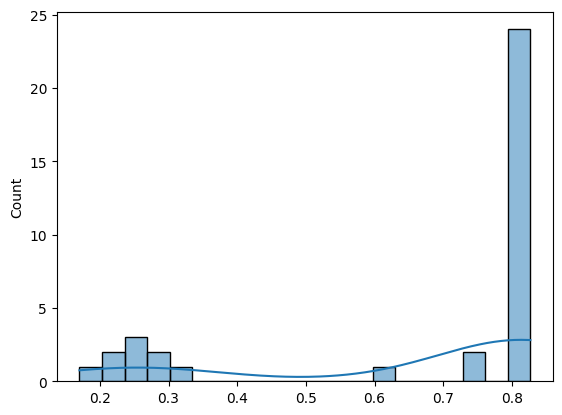

In [17]:

sns.histplot(
    ds.functional_connectivity[59334, :, 11, 0], bins=20, kde=True, stat="count"
)

In [18]:
from significantdigits import significant_digits

x = np.atanh(ds.functional_connectivity[59334, :, 11, 0])
significant_digits(x, x.mean())

array(-0.1121707)

In [19]:
x.shape

(36,)

In [20]:
x.mean()

<xarray.DataArray 'functional_connectivity' ()> Size: 8B
array(0.91068691)
Coordinates:
    cell      <U76 304B '7Networks_RH_Cont_PFCl_5, 7Networks_RH_Cont_Temp_2'
    pipeline  <U10 40B 'TrueComb5'
    subject   <U9 36B 'sub-09'

In [21]:
x = ds.functional_connectivity[22805, :, 2, 0]
significant_digits(x, x.mean())

array(5.85312051)

In [22]:
x.mean().dtype

dtype('float64')

In [23]:


def make_sigdigs_vector(pipeline_index: int, subject_index: int = 0):
    x = np.asarray(ds.functional_connectivity[:, :, pipeline_index, subject_index]).transpose()
    x.shape
    sigdigs = significant_digits(x, x.mean(axis=0), dtype=x.dtype, basis=10)
    sigdigs, sigdigs.shape
    invalid = np.isfinite(x).sum(axis=0) < 90
    sigdigs[invalid] = np.nan
    return sigdigs


def make_sigdigs_array(pipeline_index: int, subject_index: int = 0):
    array = np.full(fill_value=np.nan, shape=(k, k))
    array[*np.tril_indices(k, -1)] = make_sigdigs_vector(pipeline_index, subject_index)
    return array

def make_sigdigs_plot(title: str, ax: Axes, pipeline_index: int, subject_index: int = 0):
    array = make_sigdigs_array(pipeline_index, subject_index)
    sns.heatmap(array, vmax=4, vmin=-4, cmap="RdYlGn", ax=ax, )
    ax.set_title(f"{title}\n(mean = {np.nanmean(array):.2f})")

In [24]:
x

<xarray.DataArray 'functional_connectivity' (iteration: 36)> Size: 288B
array([0.89033114, 0.88832504, 0.88988364, 0.89171374, 0.89279896,
       0.89022177, 0.88389978, 0.88804751, 0.883302  , 0.88801886,
       0.89205305, 0.88281168, 0.89498119, 0.89085759, 0.87324723,
       0.87913637, 0.88565867, 0.89491585, 0.89346131, 0.88583081,
       0.88563898, 0.88314609, 0.88354403, 0.88023917, 0.88741051,
       0.8884211 , 0.8933818 , 0.8740947 , 0.87568275, 0.89050702,
       0.8757925 , 0.88467255, 0.87795316, 0.88577922, 0.89059127,
       0.87753479])
Coordinates:
    cell       <U76 304B '7Networks_RH_Vis_15, 7Networks_LH_Vis_15'
  * iteration  (iteration) int64 288B 0 1 2 3 4 5 6 7 ... 29 30 31 32 33 34 35
    pipeline   <U10 40B 'FalseComb2'
    subject    <U9 36B 'sub-09'

In [25]:
sigdigs = significant_digits(x, x.mean(axis=0), dtype=x.dtype, basis=10)
sigdigs, sigdigs.shape

(np.float64(1.7619648421031424), ())

In [26]:
list(enumerate(pipelines))

[(0, 'FalseComb0'),
 (1, 'FalseComb1'),
 (2, 'FalseComb2'),
 (3, 'FalseComb3'),
 (4, 'FalseComb4'),
 (5, 'FalseComb5'),
 (6, 'TrueComb0'),
 (7, 'TrueComb1'),
 (8, 'TrueComb2'),
 (9, 'TrueComb3'),
 (10, 'TrueComb4'),
 (11, 'TrueComb5')]

/var/folders/vd/rmh6fphd7n50v7gqryqln3wc0000gp/T/ipykernel_43626/11326119.py:19: RuntimeWarning: Mean of empty slice
  ax.set_title(f"{title}\n(mean = {np.nanmean(array):.2f})")
/var/folders/vd/rmh6fphd7n50v7gqryqln3wc0000gp/T/ipykernel_43626/11326119.py:19: RuntimeWarning: Mean of empty slice
  ax.set_title(f"{title}\n(mean = {np.nanmean(array):.2f})")
/var/folders/vd/rmh6fphd7n50v7gqryqln3wc0000gp/T/ipykernel_43626/11326119.py:19: RuntimeWarning: Mean of empty slice
  ax.set_title(f"{title}\n(mean = {np.nanmean(array):.2f})")
/var/folders/vd/rmh6fphd7n50v7gqryqln3wc0000gp/T/ipykernel_43626/11326119.py:19: RuntimeWarning: Mean of empty slice
  ax.set_title(f"{title}\n(mean = {np.nanmean(array):.2f})")


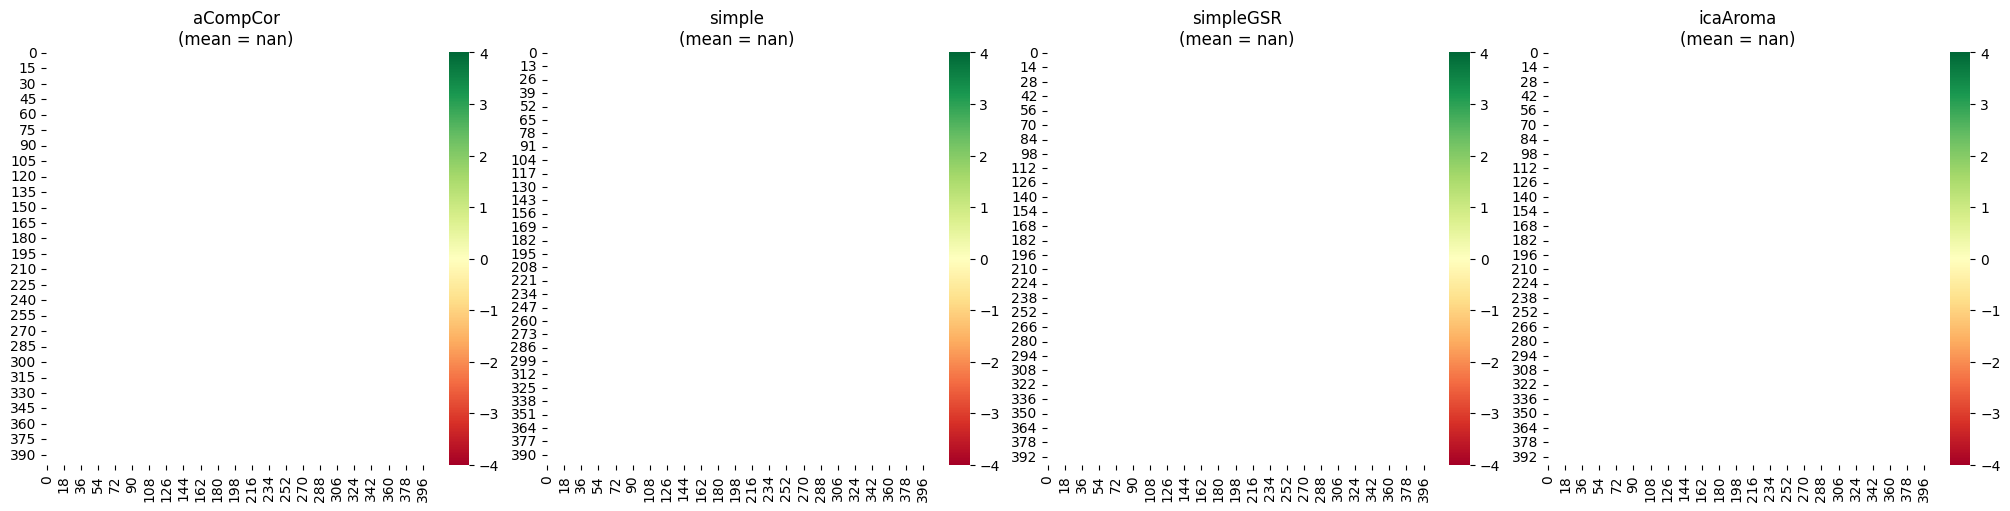

In [27]:

figure, axes_array = plt.subplots(
    ncols=4, sharex=True, figsize=(20, 5), constrained_layout=True
)

subject_index = 0
make_sigdigs_plot("aCompCor", axes_array[0], 1, subject_index)
make_sigdigs_plot("simple", axes_array[1], 3, subject_index)
make_sigdigs_plot("simpleGSR", axes_array[2], 4, subject_index)
make_sigdigs_plot("icaAroma", axes_array[3], 6, subject_index)

In [28]:
import scipy.stats

scipy.stats.ttest_rel(make_sigdigs_vector(1), make_sigdigs_vector(6), nan_policy="omit")

TtestResult(statistic=np.float64(nan), pvalue=np.float64(nan), df=np.float64(nan))

In [29]:
import numpy.ma as ma

a, b = make_sigdigs_vector(1, 1), make_sigdigs_vector(6, 1)
ma.corrcoef(ma.masked_invalid(a), ma.masked_invalid(b))

masked_array(
  data=[[--, --],
        [--, --]],
  mask=[[ True,  True],
        [ True,  True]],
  fill_value=1e+20,
  dtype=float64)

(-2.0, 3.0)

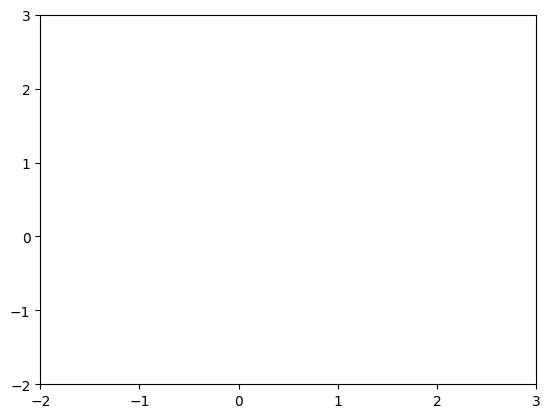

In [30]:
plt.plot(make_sigdigs_vector(1), make_sigdigs_vector(6), ".", alpha=0.1)
plt.ylim(-2, 3)
plt.xlim(-2, 3)

In [31]:
np.nanmean(make_signdigs_array(1)), np.nanmean(make_signdigs_array(6))

NameError: name 'make_signdigs_array' is not defined

In [ ]:
# ds.to_netcdf(
#     "/lea/downloads/saved_on_disk.h5",
#     engine="h5netcdf",
#     encoding=dict(
#         functional_connectivity=dict(
#             compression="gzip", compression_opts=9, shuffle=True
#         )
#     ),
# )

In [ ]:
mean = ds.functional_connectivity.mean(axis=(1))

In [ ]:
ds.functional_connectivity[:, :, 0, 0].shape, mean[:, 0, 0, np.newaxis].shape

IndexError: too many indices

In [ ]:
xr.corr(ds.functional_connectivity[:, :, 0, 0], mean[:, 0, 0], dim="cell")

<xarray.DataArray 'functional_connectivity' (iteration: 24)> Size: 192B
array([0.99923982, 0.99957016, 0.99952658, 0.99984358, 0.99936642,
       0.99985159, 0.99931692, 0.99910059, 0.99941936, 0.99982286,
       0.99961469, 0.99947921, 0.99958417, 0.99984571, 0.99984558,
       0.99987973, 0.9993567 , 0.99882917, 0.99953976, 0.99986983,
       0.99987564, 0.99963076, 0.99951181, 0.99947254])
Coordinates:
  * iteration  (iteration) int64 192B 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23
    pipeline   <U10 40B 'FalseComb0'
    subject    <U9 36B 'sub-01'

In [ ]:
np.corrcoef(ds.functional_connectivity[:, :, 0, 0]).shape

### Seed Connectivity

In [ ]:
seed = np.load('/Volumes/HALFpipe/sub-9040_seed.npz')


/Users/junzhou/opt/anaconda3/envs/halfpip/lib/python3.12/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)
/var/folders/vd/rmh6fphd7n50v7gqryqln3wc0000gp/T/ipykernel_43626/3781939454.py:10: RuntimeWarning: Mean of empty slice
  gc = sns.heatmap(np.nanmean(sigdigs, axis=0)[:, ::-1].T, ax=axes[0], cmap=cmap, vmin=-4, vmax=15, cbar=False)
/var/folders/vd/rmh6fphd7n50v7gqryqln3wc0000gp/T/ipykernel_43626/3781939454.py:12: RuntimeWarning: All-NaN slice encountered
  gc = sns.heatmap(np.nanmax(sigdigs, axis=0)[:, ::-1].T, ax=axes[1], cmap=cmap, vmin=-4, vmax=15, cbar=False)
/var/folders/vd/rmh6fphd7n50v7gqryqln3wc0000gp/T/ipykernel_43626/3781939454.py:14: RuntimeWarning: All-NaN slice encountered
  gc = sns.heatmap(np.nanmin(sigdigs, axis=0)[:, ::-1].T, ax=axes[2], cmap=cmap, vmin=-4, vmax=15, cbar=True)
/Users/junzhou/opt/anaconda3/envs/halfpip/lib/python3.12/site-packages/significantdigits/_signifi

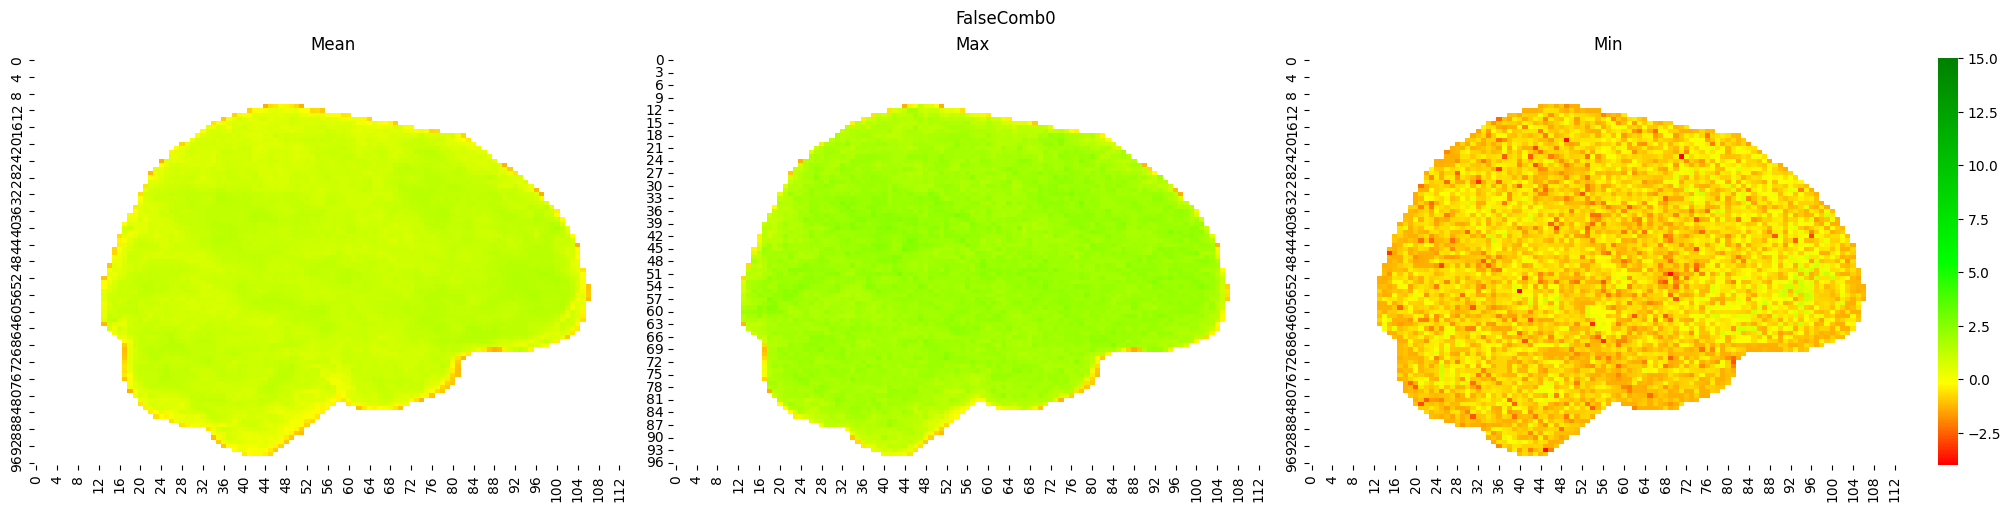

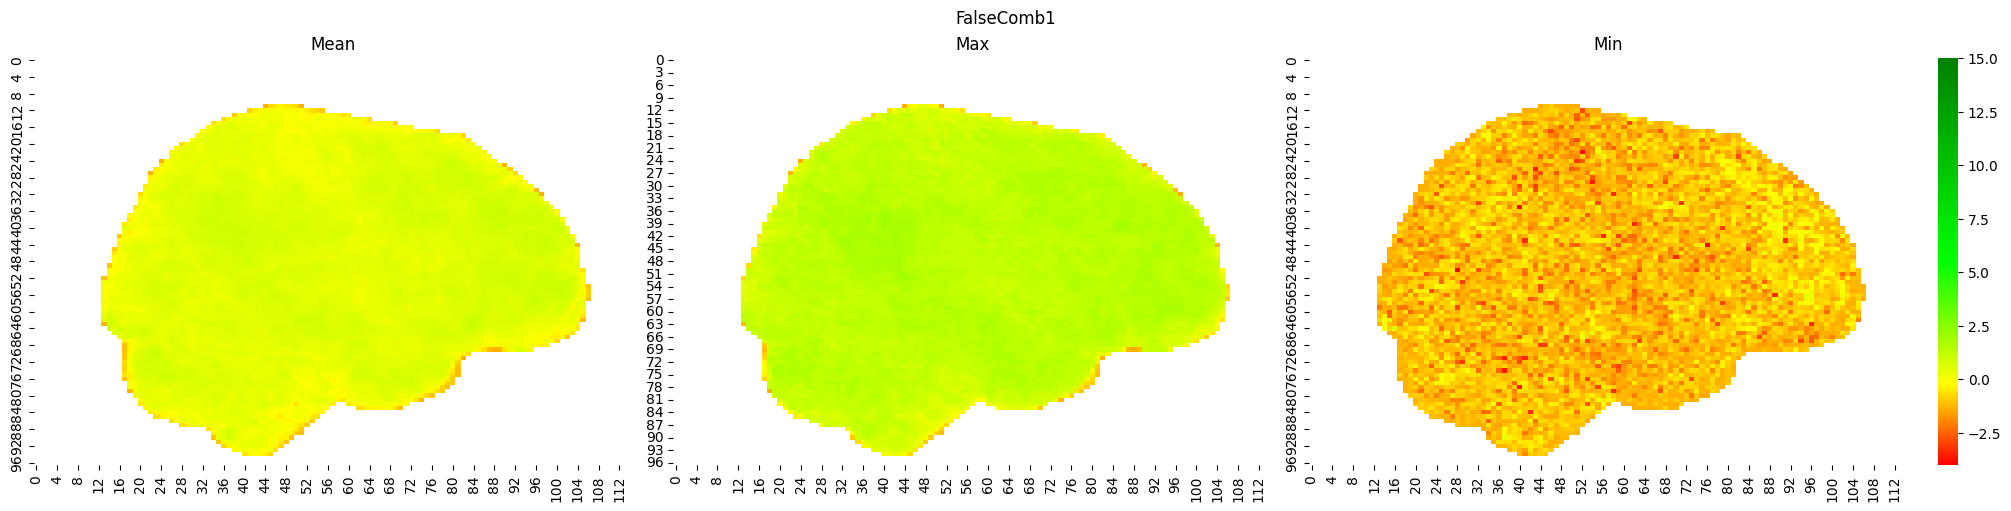

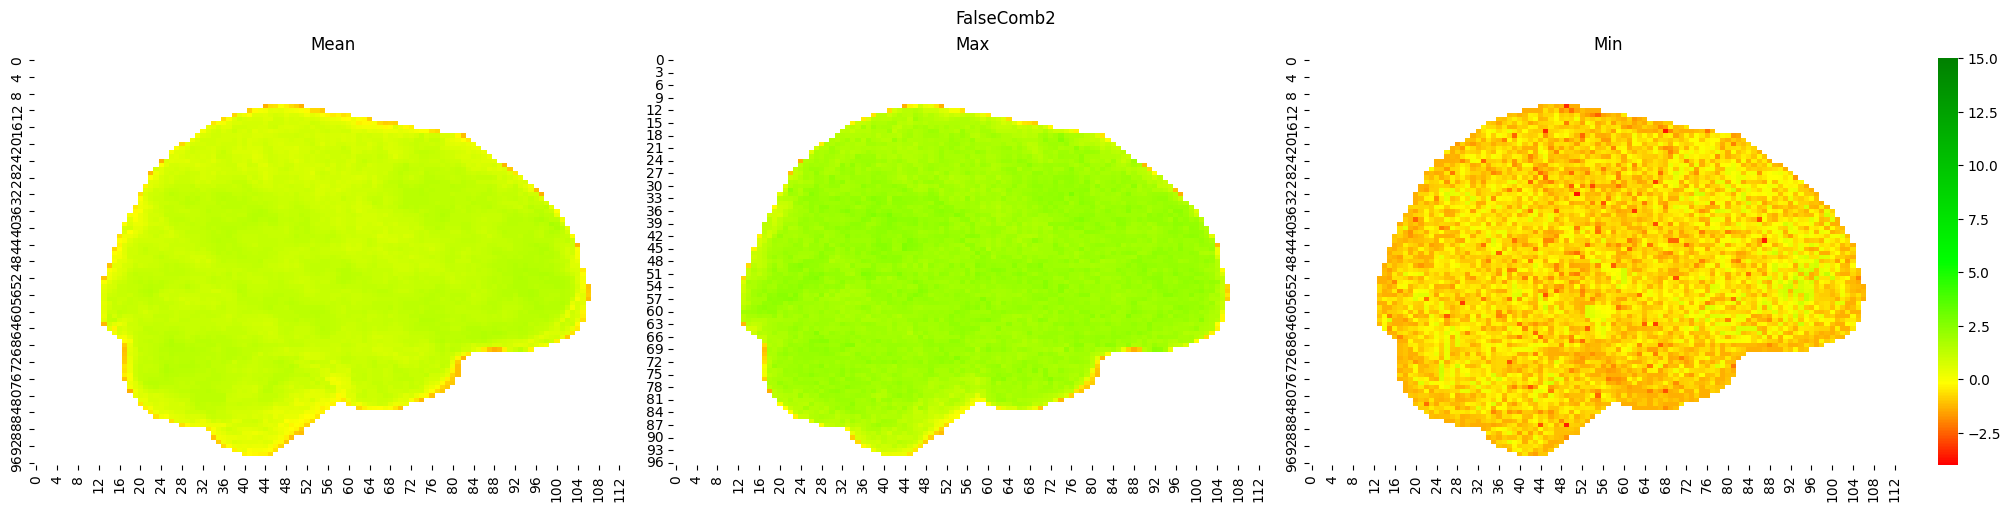

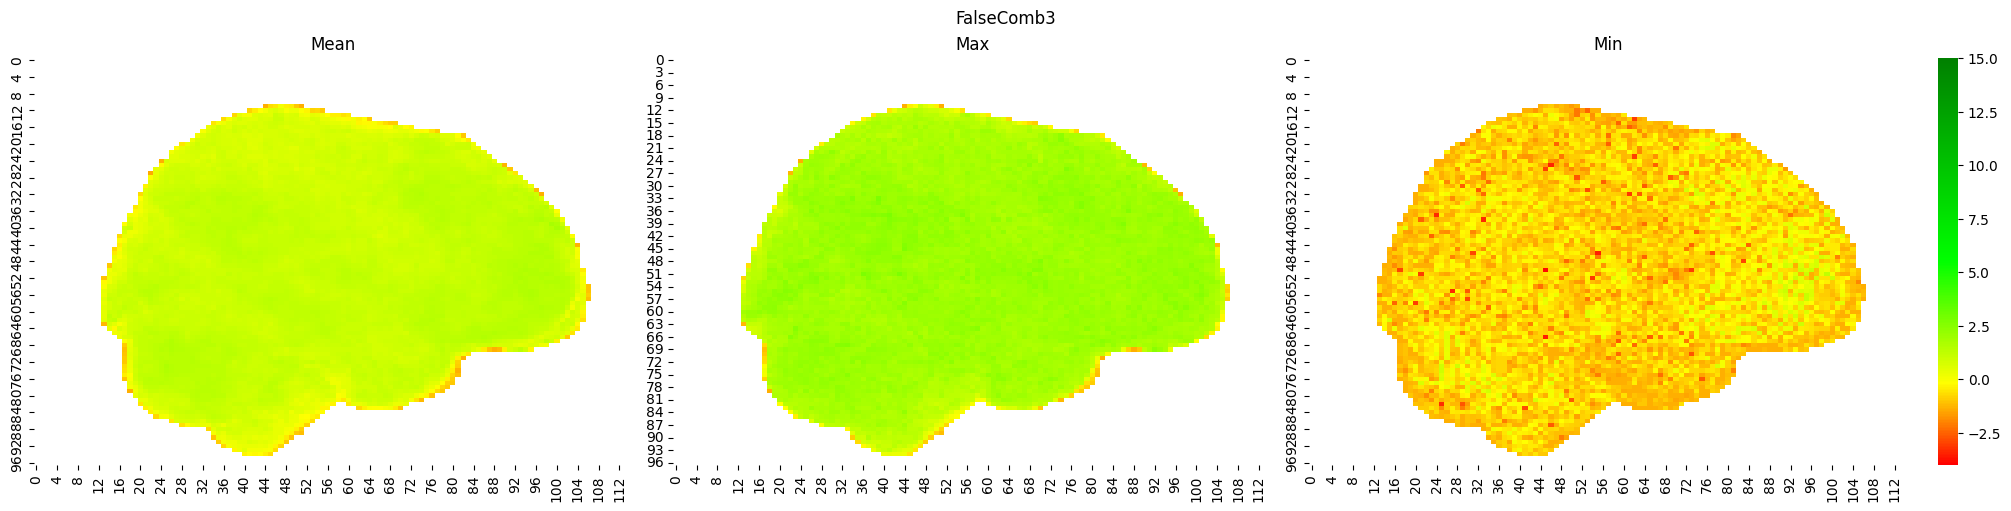

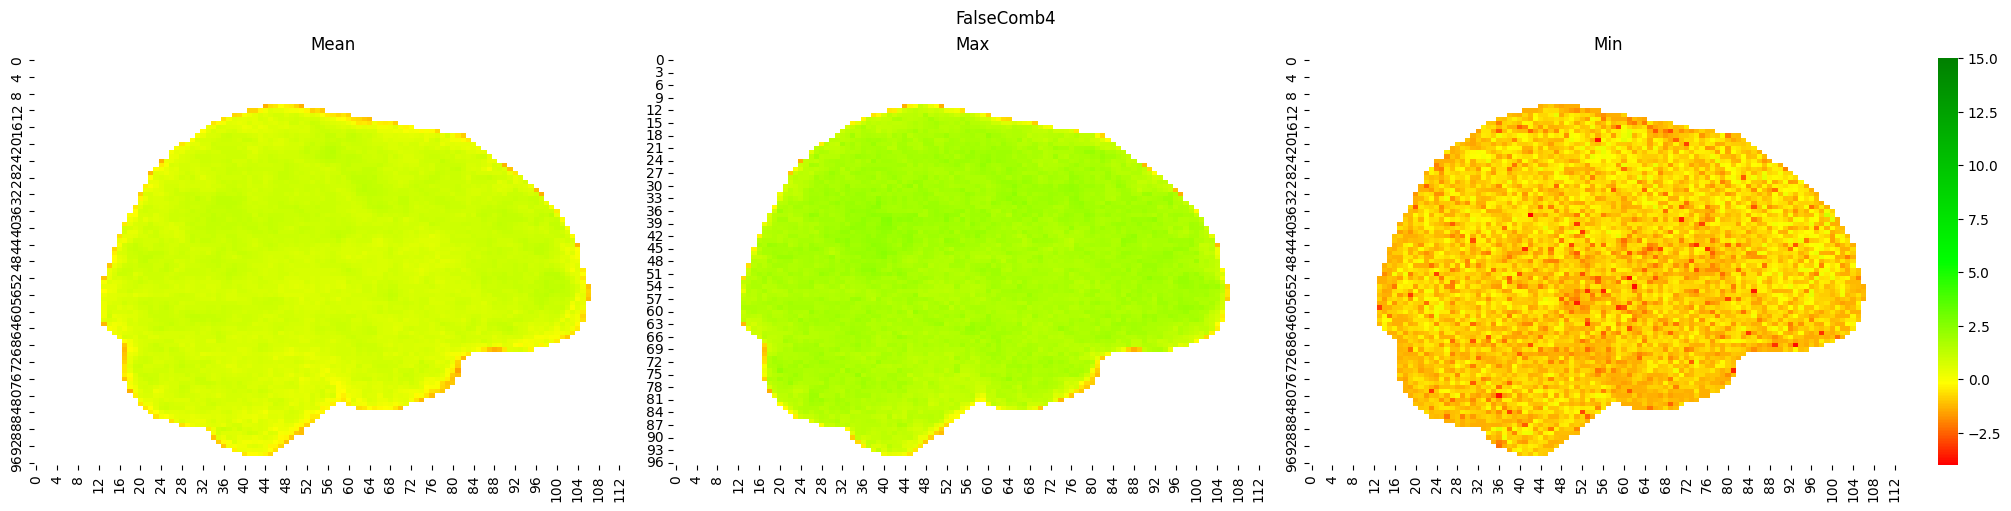

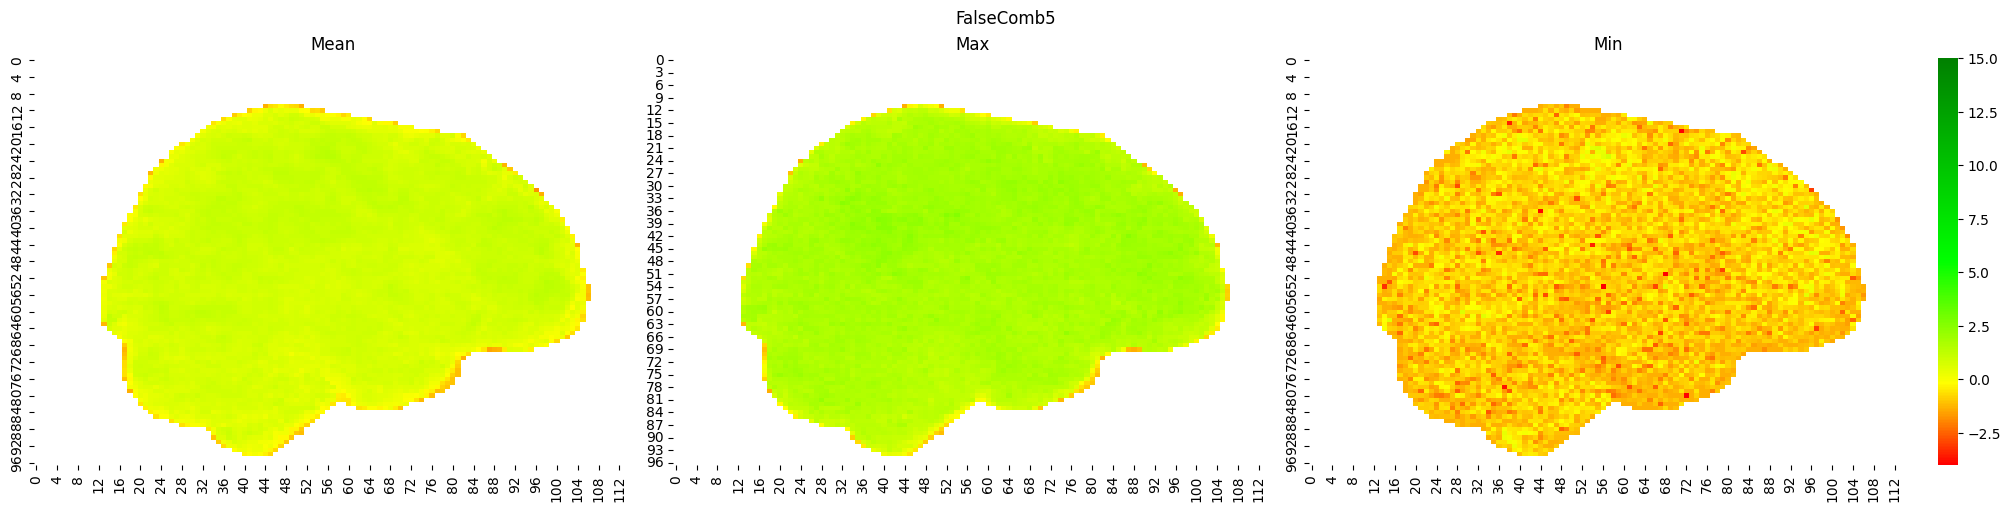

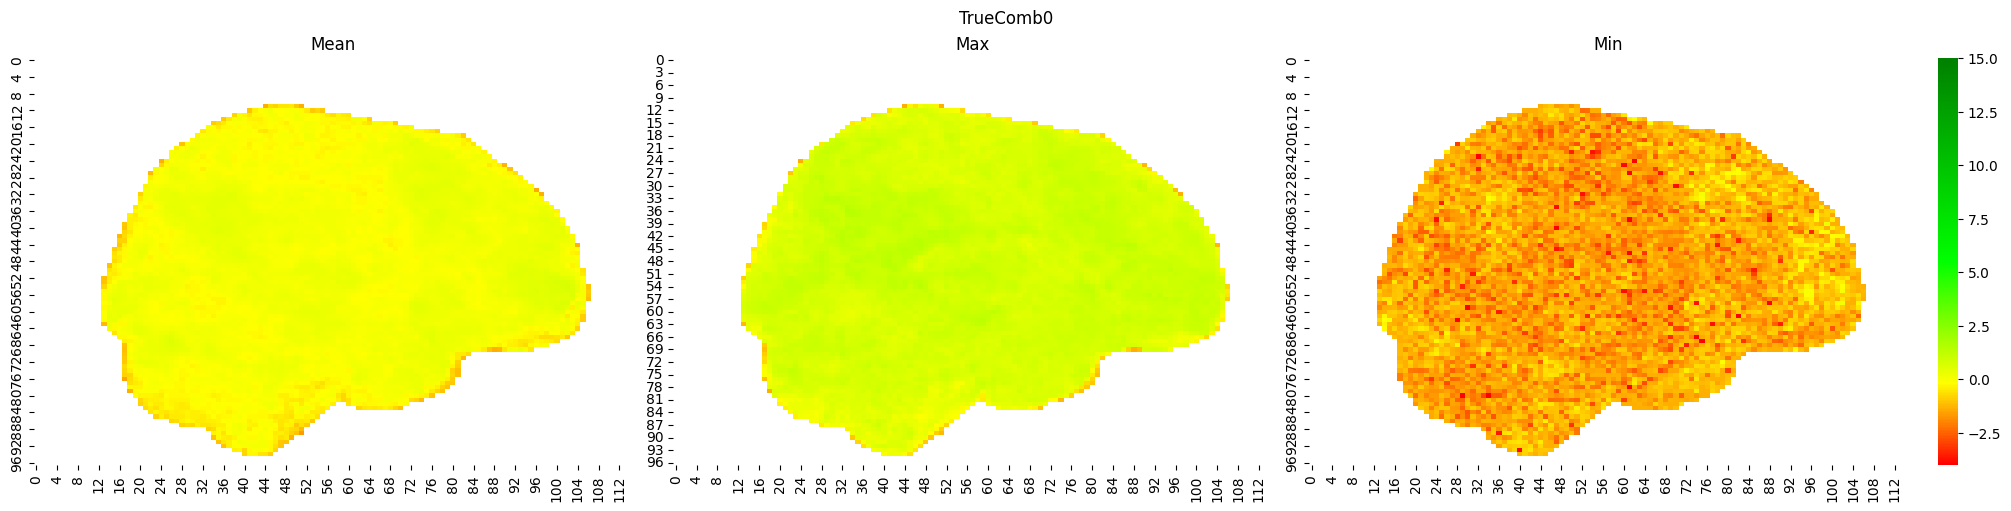

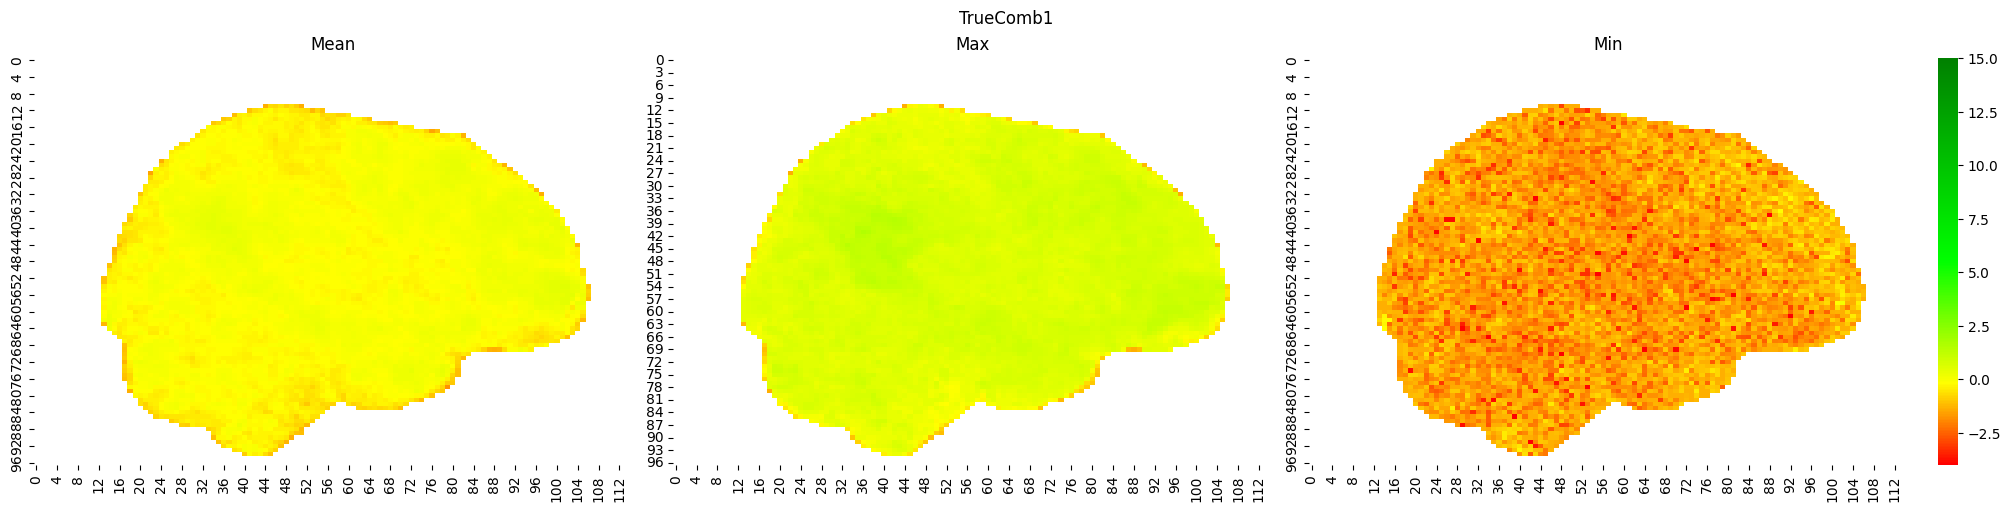

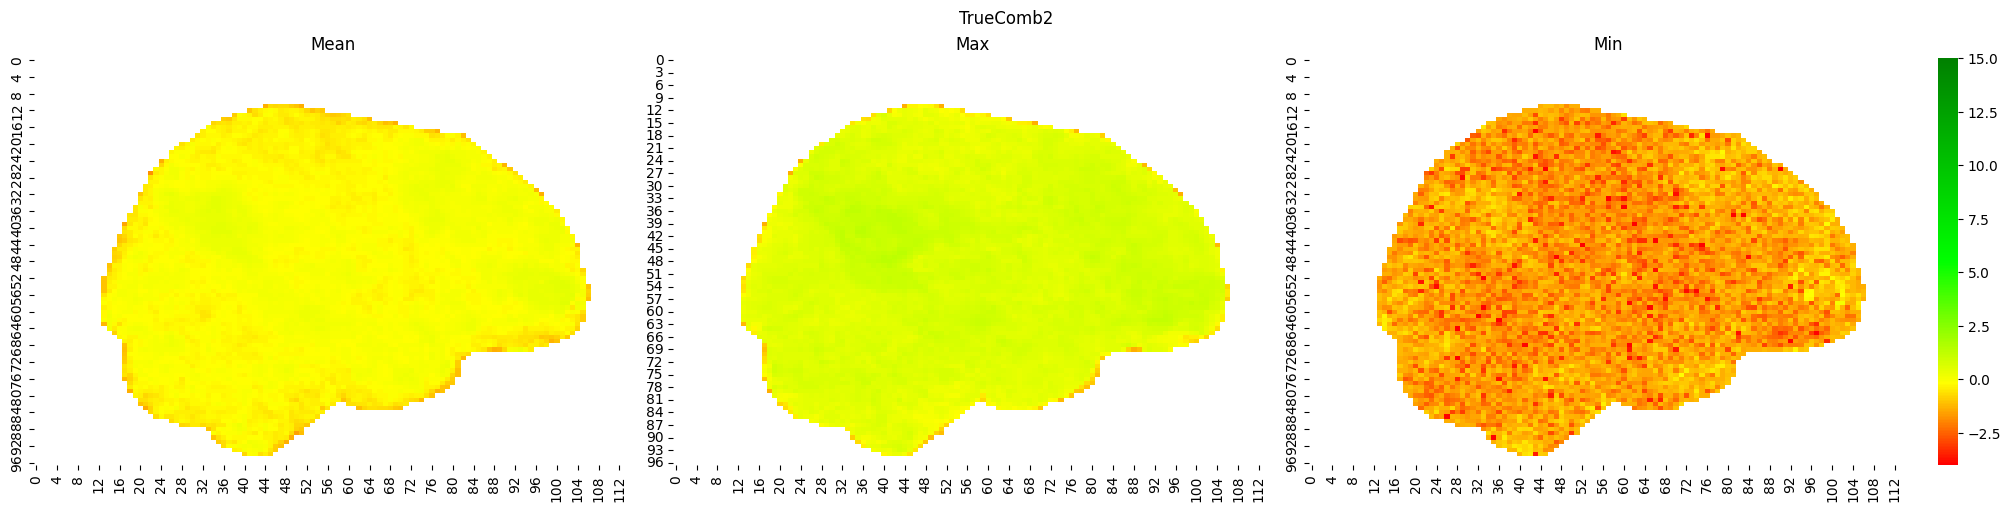

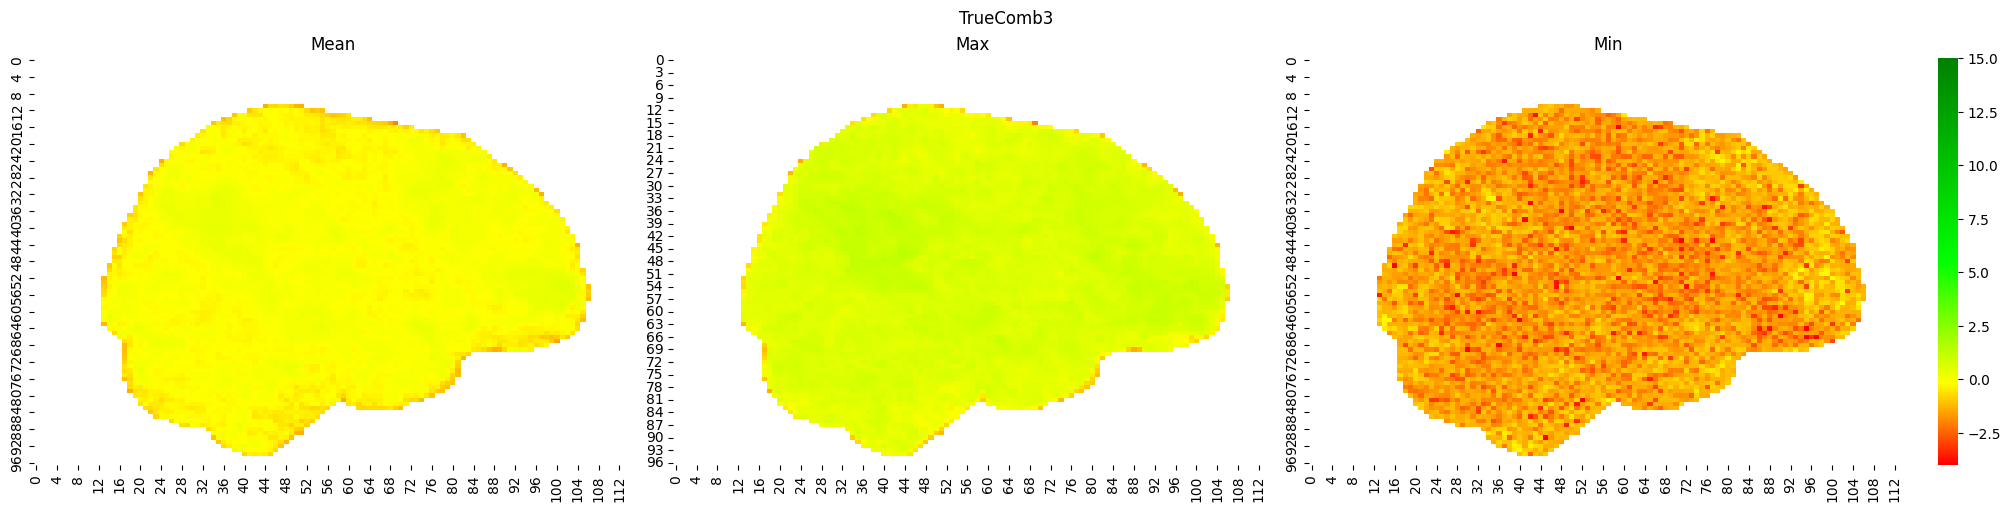

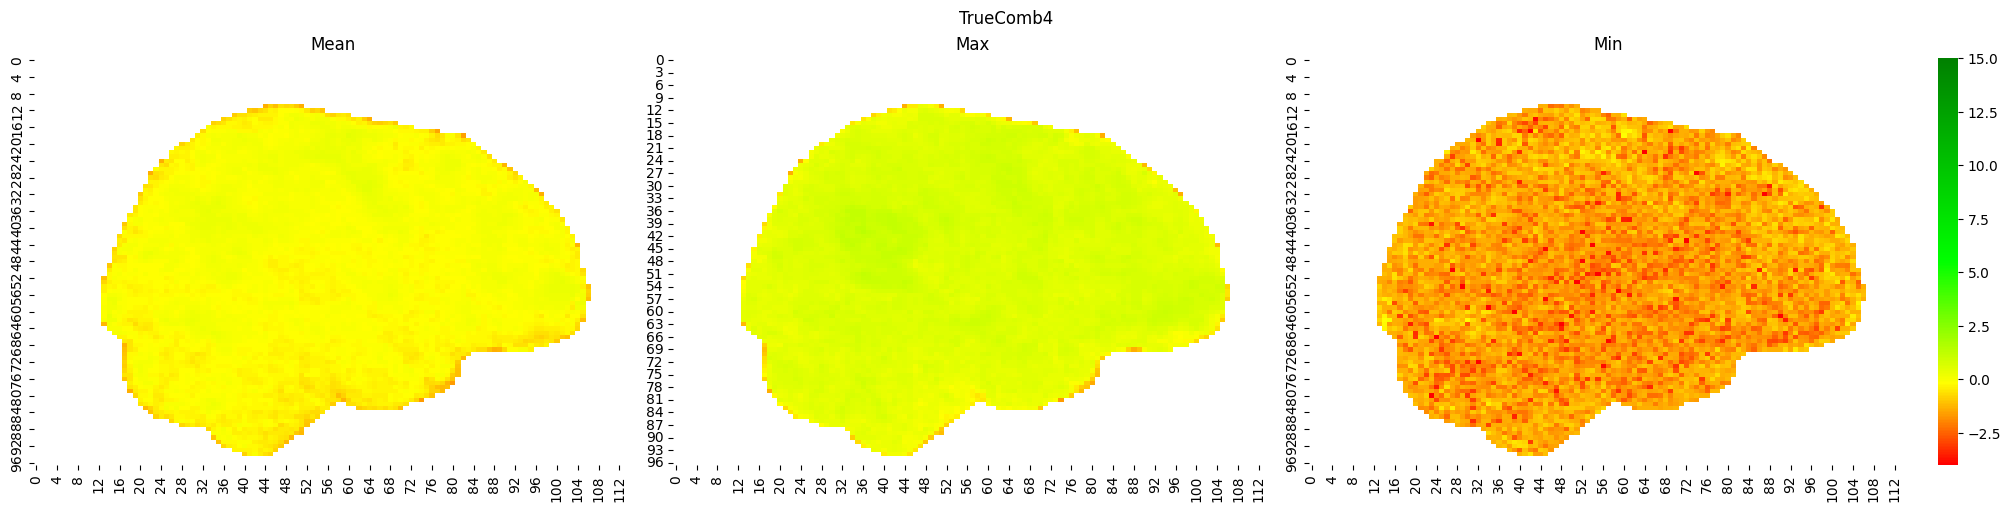

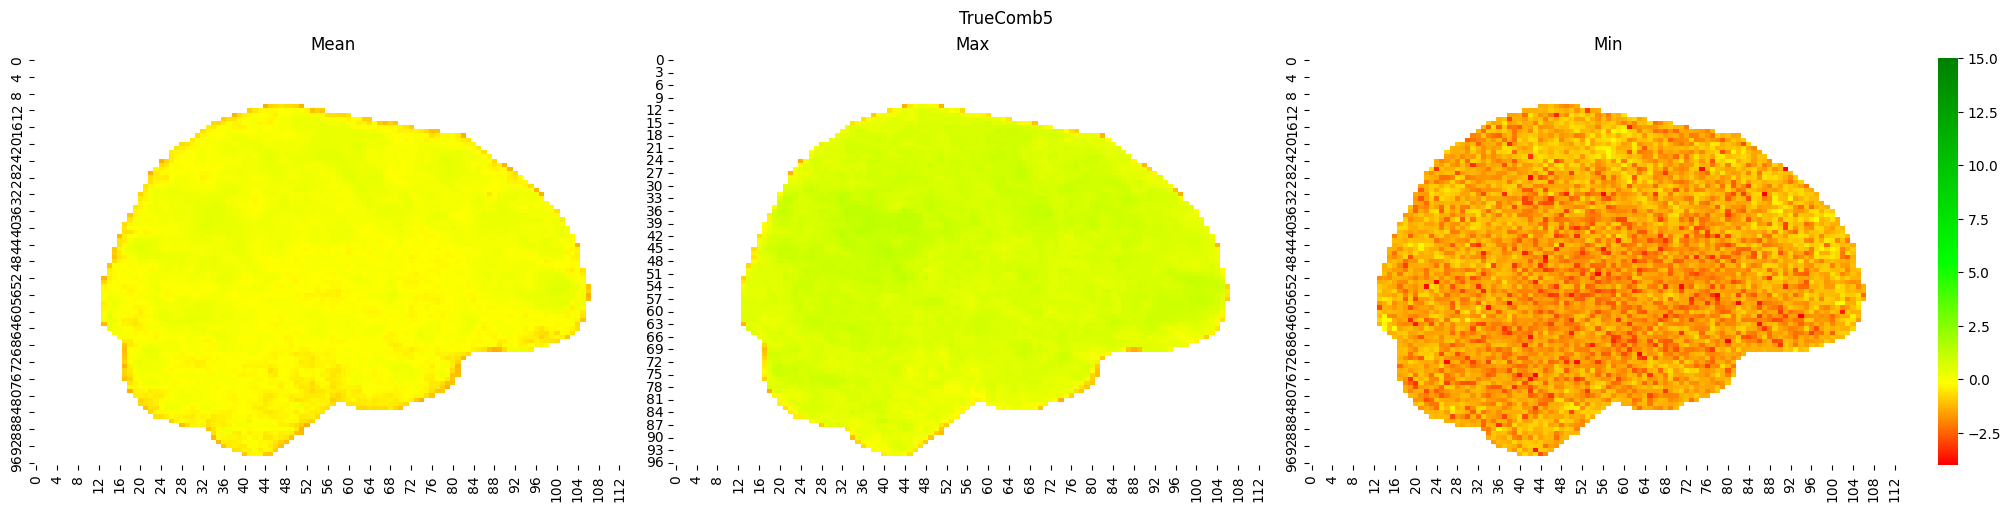

In [ ]:

colors = ['Red', 'yellow', 'lime', 'green']
values = np.array([0, 0.2, 0.5, 1])
cmap = LinearSegmentedColormap.from_list("gangchen", list(zip(values, colors)))

for num,  pre_process in list(enumerate(pipelines)):
    sigdigs = sd.significant_digits(seed['arr_0'][num], reference=seed['arr_0'][num].mean(axis=0), basis=10)
    sigdigs[sigdigs >= 15] = np.nan
    fig, axes = plt.subplots(ncols=3, sharex=True, figsize=(20,5), constrained_layout=True)

    gc = sns.heatmap(np.nanmean(sigdigs, axis=0)[:, ::-1].T, ax=axes[0], cmap=cmap, vmin=-4, vmax=15, cbar=False)
    gc.set_title('Mean')
    gc = sns.heatmap(np.nanmax(sigdigs, axis=0)[:, ::-1].T, ax=axes[1], cmap=cmap, vmin=-4, vmax=15, cbar=False)
    gc.set_title('Max')
    gc = sns.heatmap(np.nanmin(sigdigs, axis=0)[:, ::-1].T, ax=axes[2], cmap=cmap, vmin=-4, vmax=15, cbar=True)
    gc.set_title('Min')
    plt.suptitle(pre_process)
    # break

/var/folders/vd/rmh6fphd7n50v7gqryqln3wc0000gp/T/ipykernel_43626/3771921850.py:3: RuntimeWarning: Mean of empty slice
  gc = sns.heatmap(np.nanmean(sigdigs, axis=0)[:, ::-1].T, ax=axes[0], cmap=cmap, vmin=-4, vmax=15, cbar=False)
/var/folders/vd/rmh6fphd7n50v7gqryqln3wc0000gp/T/ipykernel_43626/3771921850.py:5: RuntimeWarning: All-NaN slice encountered
  gc = sns.heatmap(np.nanmax(sigdigs, axis=0)[:, ::-1].T, ax=axes[1], cmap=cmap, vmin=-4, vmax=15, cbar=False)
/var/folders/vd/rmh6fphd7n50v7gqryqln3wc0000gp/T/ipykernel_43626/3771921850.py:7: RuntimeWarning: All-NaN slice encountered
  gc = sns.heatmap(np.nanmin(sigdigs, axis=0)[:, ::-1].T, ax=axes[2], cmap=cmap, vmin=-4, vmax=15, cbar=True)


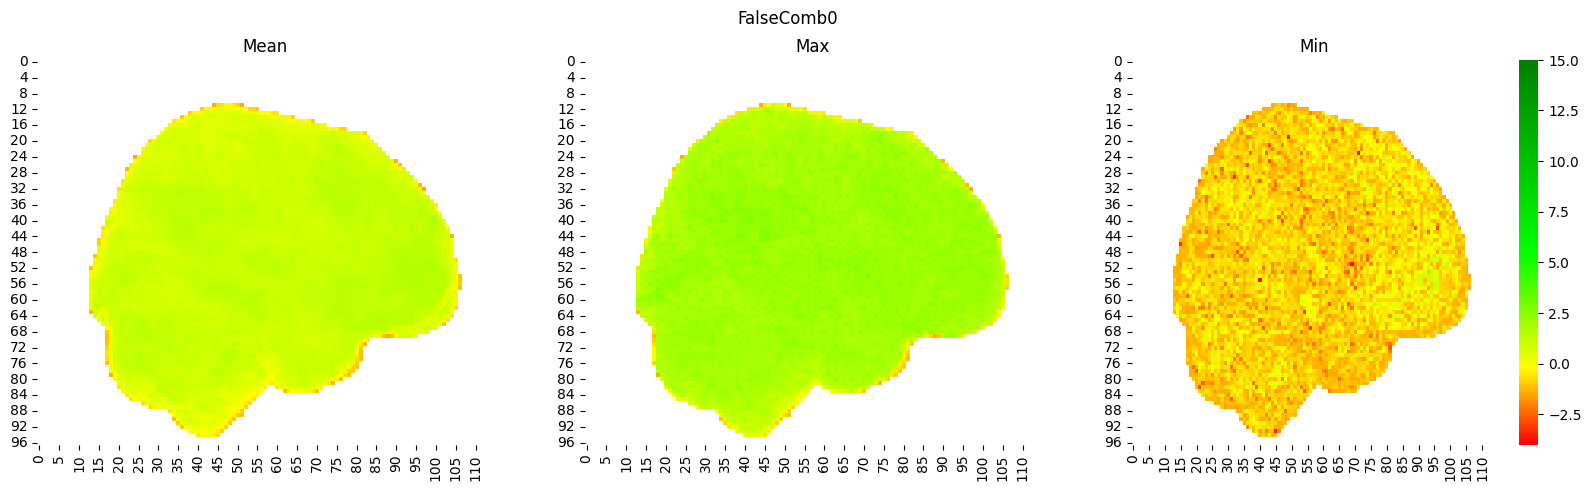

In [ ]:
fig, axes = plt.subplots(ncols=3, sharex=True, figsize=(20,5), )

gc = sns.heatmap(np.nanmean(sigdigs, axis=0)[:, ::-1].T, ax=axes[0], cmap=cmap, vmin=-4, vmax=15, cbar=False)
gc.set_title('Mean')
gc = sns.heatmap(np.nanmax(sigdigs, axis=0)[:, ::-1].T, ax=axes[1], cmap=cmap, vmin=-4, vmax=15, cbar=False)
gc.set_title('Max')
gc = sns.heatmap(np.nanmin(sigdigs, axis=0)[:, ::-1].T, ax=axes[2], cmap=cmap, vmin=-4, vmax=15, cbar=True)
gc.set_title('Min')
plt.suptitle(pre_process);